In [ ]:
import gym
import numpy  as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


In [9]:
env = gym.make('CartPole-v1')
print(f'Statement space dim : {len(env.observation_space.bounded_below)}')
print(f'Action space dim : {env.action_space.n}')

Statement space dim : 4
Action space dim : 2


In [10]:
LR = 1e-4
GAMMA = 0.98    # 할인율
LAMBDA = 0.95    
EPSILON = 0.1    # clipping 할 때 사용하는 epsilon 
K_EPOCH = 3
T_HORIZION = 20
N_EPOCH = 5000
BETA = 0.5

STATE_DIM = 4
ACTION_DIM = 2

In [11]:
class Network(nn.Module):
  def __init__(self, state_dim, hidden_unit, action_dim):
    super(Network, self).__init__()

    # arguments
    self.state_dim = state_dim
    self.hidden_unit = hidden_unit
    self.action_dim = action_dim

    # layers
    self.fc = nn.Linear(self.state_dim, self.hidden_unit)
    self.fc_v = nn.Linear(self.hidden_unit, 1)
    self.fc_pi = nn.Linear(self.hidden_unit, self.action_dim)

  def pi(self, x, soft_dim = 0):
    x = F.relu(self.fc(x))
    return F.softmax(self.fc_pi(x), soft_dim)

  def v(self, x):
    x = F.relu(self.fc(x))
    return F.relu(self.fc_v(x))

In [12]:
class Util:
  def __init__(self):
    self.data = []

  def append(self, item):
    self.data.append(item)

  def preprocess(self):
      state_lst, action_lst, reward_lst, next_state_lst, prob_lst, done_lst = [], [], [], [], [], []
      for transition in self.data:
        state, action, reward, next_state, prob, done = transition
        state_lst.append(state)
        action_lst.append([action])
        reward_lst.append([reward])
        next_state_lst.append(next_state)
        prob_lst.append([prob])
        done_mask = 0 if done else 1
        done_lst.append([done_mask])
      
      # list ---> tensor
      state_tensor = torch.tensor(state_lst, dtype=torch.float)
      action_tensor = torch.tensor(action_lst)
      reward_tensor = torch.tensor(reward_lst)
      next_state_tensor = torch.tensor(next_state_lst, dtype=torch.float)
      done_mask = torch.tensor(done_lst, dtype=torch.float)
      prob_tensor = torch.tensor(prob_lst)

      # initialize
      self.data = []

      return state_tensor, action_tensor, reward_tensor, \
            next_state_tensor, done_mask, prob_tensor

In [14]:
class PPO(nn.Module):
  def __init__(self, env, net, lr):
    super(PPO, self).__init__()
    self.env = env
    self.net = net
    self.util = Util()
    self.lr = lr
    self.opt = optim.Adam(self.net.parameters(), lr = self.lr)
    self.loss_record = []

  def train(self, n_epoch = 20, k_epoch = 10, t_horizion = 20,
            Lambda = 0.9, gamma = 0.9, epsilon = 0.1, beta = 0.5):
    self.loss_record = []
    for epoch in range(n_epoch):
      # Initialize
      state = self.env.reset()
      done = False
      
      while not done:
        for _ in range(t_horizion):
          prob = net.pi(torch.from_numpy(state).float())
          action = Categorical(prob).sample().item()
          prob_a = prob[action].item()
          next_state, reward, done, info = self.env.step(action)
          self.util.append((state, action, reward, next_state, prob_a, done))
          state = next_state
          if done:
              break

        states, actions, rewards, next_states, dones, pi_olds = self.util.preprocess()

        #--- Update network k_epoch times ---#
        for _ in range(k_epoch):
          self.opt.zero_grad()
          #--- Caclulating td target and delta ---#
          td_targets = rewards + gamma*self.net.v(next_states)*dones
          deltas = (td_targets - self.net.v(states)).detach().numpy()
          #--- Caculating Advantage Function ---#
          A = 0.
          A_lst = []
          for delta in deltas[::-1]:
            A = gamma*Lambda*A+delta[0]
            A_lst.append([A])
          A_lst.reverse()
          A_tensor = torch.tensor(A_lst, dtype = torch.float)
          
          #--- Caculating ratio of pi ---#
          pi_new = self.net.pi(states, soft_dim = 1).gather(1, actions)
          ratio = torch.exp(torch.log(pi_new) - torch.log(pi_olds))

          #--- Surrogate Object ---#
          surrogate1 = ratio*A_tensor
          surrogate2 = torch.clamp(ratio, 1-epsilon, 1+epsilon)*A_tensor
          clipping_surrogate = torch.min(surrogate1, surrogate2)

          #--- KL penalty ---#
          kl_penalty = beta* F.smooth_l1_loss(self.net.v(states), td_targets.detach())

          #--- loss ---#
          loss = (-clipping_surrogate + kl_penalty).mean()
       
          #--- update ---#
          loss.backward()
          self.opt.step()

      # log
      loss = loss.detach().item()
      self.loss_record.append(loss)
      print(f'{epoch + 1} epoch  loss : {loss}')

1 epoch  loss : -4.272789478302002
2 epoch  loss : -4.85491943359375
3 epoch  loss : -2.0865137577056885
4 epoch  loss : -4.265903472900391
5 epoch  loss : -4.250006675720215
6 epoch  loss : -2.879507064819336
7 epoch  loss : -5.1375250816345215
8 epoch  loss : -4.570837020874023
9 epoch  loss : -1.6600347757339478
10 epoch  loss : -5.138724327087402
11 epoch  loss : -4.861539363861084
12 epoch  loss : -4.869014263153076
13 epoch  loss : -3.598722219467163
14 epoch  loss : -1.6580864191055298
15 epoch  loss : -2.4875597953796387
16 epoch  loss : -5.4112372398376465
17 epoch  loss : -6.398038864135742
18 epoch  loss : -6.375124454498291
19 epoch  loss : -6.158300399780273
20 epoch  loss : -5.416327476501465
21 epoch  loss : -6.802369594573975
22 epoch  loss : -4.854783535003662
23 epoch  loss : -6.806631565093994
24 epoch  loss : -5.669775009155273
25 epoch  loss : -5.665315628051758
26 epoch  loss : -6.808463096618652
27 epoch  loss : -6.597445487976074
28 epoch  loss : -2.483412504196

247 epoch  loss : 1.3410392999649048
248 epoch  loss : 0.13378937542438507
249 epoch  loss : 0.8731025457382202
250 epoch  loss : -1.1532925367355347
251 epoch  loss : 1.1313021183013916
252 epoch  loss : -1.2908974885940552
253 epoch  loss : -2.9014291763305664
254 epoch  loss : -1.2502937316894531
255 epoch  loss : -0.778237521648407
256 epoch  loss : -1.8433696031570435
257 epoch  loss : -1.3601386547088623
258 epoch  loss : -1.9471880197525024
259 epoch  loss : -1.895495891571045
260 epoch  loss : 0.2225867658853531
261 epoch  loss : -2.0063467025756836
262 epoch  loss : -0.5482277870178223
263 epoch  loss : -3.1215648651123047
264 epoch  loss : -1.2675895690917969
265 epoch  loss : 0.5147157311439514
266 epoch  loss : -4.120951175689697
267 epoch  loss : -0.3451661765575409
268 epoch  loss : -1.0880839824676514
269 epoch  loss : 1.9208457469940186
270 epoch  loss : 1.6716384887695312
271 epoch  loss : 8.076074600219727
272 epoch  loss : -3.035832643508911
273 epoch  loss : -2.6855

470 epoch  loss : 5.105799198150635
471 epoch  loss : 6.319945812225342
472 epoch  loss : 1.8593991994857788
473 epoch  loss : 0.8481175303459167
474 epoch  loss : 2.696963310241699
475 epoch  loss : 2.737311840057373
476 epoch  loss : 0.8413216471672058
477 epoch  loss : 10.30741024017334
478 epoch  loss : 2.5038881301879883
479 epoch  loss : 0.3872566223144531
480 epoch  loss : 23.47342300415039
481 epoch  loss : 4.423841953277588
482 epoch  loss : 0.8367722630500793
483 epoch  loss : 6.514221668243408
484 epoch  loss : 0.570051372051239
485 epoch  loss : 0.3532741069793701
486 epoch  loss : -1.1006895303726196
487 epoch  loss : 2.996157169342041
488 epoch  loss : 16.842256546020508
489 epoch  loss : 2.4173803329467773
490 epoch  loss : 8.894194602966309
491 epoch  loss : 4.6344122886657715
492 epoch  loss : 5.866796970367432
493 epoch  loss : 6.168832778930664
494 epoch  loss : 3.9877254962921143
495 epoch  loss : 4.389191627502441
496 epoch  loss : 5.644111156463623
497 epoch  loss

702 epoch  loss : 25.010513305664062
703 epoch  loss : 11.873228073120117
704 epoch  loss : 18.00448989868164
705 epoch  loss : 19.14643096923828
706 epoch  loss : 10.7238130569458
707 epoch  loss : 14.545870780944824
708 epoch  loss : 35.0281982421875
709 epoch  loss : 12.055092811584473
710 epoch  loss : 11.246794700622559
711 epoch  loss : 24.4915828704834
712 epoch  loss : 14.605232238769531
713 epoch  loss : 20.386962890625
714 epoch  loss : 17.106332778930664
715 epoch  loss : 25.05068588256836
716 epoch  loss : 11.725569725036621
717 epoch  loss : 15.325310707092285
718 epoch  loss : 15.197002410888672
719 epoch  loss : 23.175554275512695
720 epoch  loss : 27.51325035095215
721 epoch  loss : 15.134906768798828
722 epoch  loss : 16.160236358642578
723 epoch  loss : 21.703908920288086
724 epoch  loss : 17.8122615814209
725 epoch  loss : 12.58708667755127
726 epoch  loss : 20.735864639282227
727 epoch  loss : 12.180110931396484
728 epoch  loss : 26.91958236694336
729 epoch  loss : 

930 epoch  loss : 58.35990524291992
931 epoch  loss : 34.47327423095703
932 epoch  loss : 41.8760986328125
933 epoch  loss : 76.0609359741211
934 epoch  loss : 50.1648063659668
935 epoch  loss : 40.19626235961914
936 epoch  loss : 56.890541076660156
937 epoch  loss : 31.927898406982422
938 epoch  loss : 68.76937866210938
939 epoch  loss : 40.62948989868164
940 epoch  loss : 34.825889587402344
941 epoch  loss : 45.22315979003906
942 epoch  loss : 83.14209747314453
943 epoch  loss : 41.29092025756836
944 epoch  loss : 36.152374267578125
945 epoch  loss : 50.68373107910156
946 epoch  loss : 43.75700759887695
947 epoch  loss : 71.19892120361328
948 epoch  loss : 50.883209228515625
949 epoch  loss : 55.82587814331055
950 epoch  loss : 43.2556266784668
951 epoch  loss : 33.611236572265625
952 epoch  loss : 60.643218994140625
953 epoch  loss : 44.819602966308594
954 epoch  loss : 50.75841522216797
955 epoch  loss : 65.50048065185547
956 epoch  loss : 37.77839660644531
957 epoch  loss : 35.365

1156 epoch  loss : 45.0238037109375
1157 epoch  loss : 38.445091247558594
1158 epoch  loss : 36.19196319580078
1159 epoch  loss : 47.89595413208008
1160 epoch  loss : 34.835968017578125
1161 epoch  loss : 44.934452056884766
1162 epoch  loss : 69.88246154785156
1163 epoch  loss : 38.53350067138672
1164 epoch  loss : 37.901702880859375
1165 epoch  loss : 49.94163513183594
1166 epoch  loss : 40.50735855102539
1167 epoch  loss : 30.567203521728516
1168 epoch  loss : 38.64522171020508
1169 epoch  loss : 42.05890655517578
1170 epoch  loss : 33.555259704589844
1171 epoch  loss : 53.818050384521484
1172 epoch  loss : 32.64659881591797
1173 epoch  loss : 56.4084358215332
1174 epoch  loss : 63.1740837097168
1175 epoch  loss : 38.10580062866211
1176 epoch  loss : 32.92416000366211
1177 epoch  loss : 36.92337417602539
1178 epoch  loss : 49.17342758178711
1179 epoch  loss : 37.922847747802734
1180 epoch  loss : 42.317420959472656
1181 epoch  loss : 36.13267517089844
1182 epoch  loss : 51.2111206054

1378 epoch  loss : 33.158382415771484
1379 epoch  loss : 72.8319091796875
1380 epoch  loss : 76.79428100585938
1381 epoch  loss : 40.17121887207031
1382 epoch  loss : 44.38749694824219
1383 epoch  loss : 33.061439514160156
1384 epoch  loss : 59.81257247924805
1385 epoch  loss : 45.66283416748047
1386 epoch  loss : 43.349876403808594
1387 epoch  loss : 30.813583374023438
1388 epoch  loss : 37.653438568115234
1389 epoch  loss : 34.177860260009766
1390 epoch  loss : 48.1175422668457
1391 epoch  loss : 41.837684631347656
1392 epoch  loss : 47.13481903076172
1393 epoch  loss : 51.6733512878418
1394 epoch  loss : 35.60731887817383
1395 epoch  loss : 59.41408157348633
1396 epoch  loss : 33.312110900878906
1397 epoch  loss : 39.24861526489258
1398 epoch  loss : 75.10042572021484
1399 epoch  loss : 47.92794418334961
1400 epoch  loss : 39.72859573364258
1401 epoch  loss : 45.53656768798828
1402 epoch  loss : 67.29602813720703
1403 epoch  loss : 45.98953628540039
1404 epoch  loss : 41.68628311157

1601 epoch  loss : 42.784751892089844
1602 epoch  loss : 59.13917922973633
1603 epoch  loss : 30.023231506347656
1604 epoch  loss : 45.149662017822266
1605 epoch  loss : 61.58880615234375
1606 epoch  loss : 45.52701187133789
1607 epoch  loss : 45.58768081665039
1608 epoch  loss : 30.28142547607422
1609 epoch  loss : 28.72090721130371
1610 epoch  loss : 59.79235076904297
1611 epoch  loss : 59.30669403076172
1612 epoch  loss : 42.5392951965332
1613 epoch  loss : 48.678558349609375
1614 epoch  loss : 37.8195686340332
1615 epoch  loss : 28.072444915771484
1616 epoch  loss : 36.74105453491211
1617 epoch  loss : 45.25098419189453
1618 epoch  loss : 75.94982147216797
1619 epoch  loss : 29.016098022460938
1620 epoch  loss : 27.705310821533203
1621 epoch  loss : 49.519344329833984
1622 epoch  loss : 31.747514724731445
1623 epoch  loss : 45.233154296875
1624 epoch  loss : 30.04452896118164
1625 epoch  loss : 29.152376174926758
1626 epoch  loss : 61.54056930541992
1627 epoch  loss : 75.0436401367

1822 epoch  loss : 46.59029769897461
1823 epoch  loss : 42.689266204833984
1824 epoch  loss : 31.634933471679688
1825 epoch  loss : 37.291046142578125
1826 epoch  loss : 53.4019775390625
1827 epoch  loss : 32.852481842041016
1828 epoch  loss : 37.78223419189453
1829 epoch  loss : 48.44575500488281
1830 epoch  loss : 44.993560791015625
1831 epoch  loss : 57.84109115600586
1832 epoch  loss : 44.89559555053711
1833 epoch  loss : 30.900060653686523
1834 epoch  loss : 43.05925369262695
1835 epoch  loss : 30.038745880126953
1836 epoch  loss : 33.838584899902344
1837 epoch  loss : 63.7872428894043
1838 epoch  loss : 37.025184631347656
1839 epoch  loss : 31.25218391418457
1840 epoch  loss : 32.474117279052734
1841 epoch  loss : 42.49231719970703
1842 epoch  loss : 35.3628044128418
1843 epoch  loss : 31.766204833984375
1844 epoch  loss : 39.26251983642578
1845 epoch  loss : 30.565998077392578
1846 epoch  loss : 39.58602523803711
1847 epoch  loss : 37.243736267089844
1848 epoch  loss : 38.710391

2044 epoch  loss : 48.10345458984375
2045 epoch  loss : 29.304901123046875
2046 epoch  loss : 35.132484436035156
2047 epoch  loss : 39.215476989746094
2048 epoch  loss : 37.11974334716797
2049 epoch  loss : 30.48607063293457
2050 epoch  loss : 35.33161163330078
2051 epoch  loss : 32.4979362487793
2052 epoch  loss : 30.69093894958496
2053 epoch  loss : 40.04473114013672
2054 epoch  loss : 31.46152687072754
2055 epoch  loss : 31.972509384155273
2056 epoch  loss : 33.781131744384766
2057 epoch  loss : 30.7259521484375
2058 epoch  loss : 47.87364959716797
2059 epoch  loss : 50.279205322265625
2060 epoch  loss : 29.03107261657715
2061 epoch  loss : 31.921106338500977
2062 epoch  loss : 27.150577545166016
2063 epoch  loss : 33.13792419433594
2064 epoch  loss : 31.006872177124023
2065 epoch  loss : 56.45943832397461
2066 epoch  loss : 30.666797637939453
2067 epoch  loss : 27.285654067993164
2068 epoch  loss : 31.97254753112793
2069 epoch  loss : 36.693939208984375
2070 epoch  loss : 49.856769

2268 epoch  loss : 41.60929489135742
2269 epoch  loss : 43.88261795043945
2270 epoch  loss : 28.772106170654297
2271 epoch  loss : 32.90135192871094
2272 epoch  loss : 34.59718704223633
2273 epoch  loss : 37.392581939697266
2274 epoch  loss : 25.850767135620117
2275 epoch  loss : 65.00833892822266
2276 epoch  loss : 41.83301544189453
2277 epoch  loss : 24.96579933166504
2278 epoch  loss : 33.68684768676758
2279 epoch  loss : 37.50400924682617
2280 epoch  loss : 27.711429595947266
2281 epoch  loss : 31.695343017578125
2282 epoch  loss : 60.22891616821289
2283 epoch  loss : 23.76605796813965
2284 epoch  loss : 27.002805709838867
2285 epoch  loss : 42.1392936706543
2286 epoch  loss : 50.05430603027344
2287 epoch  loss : 35.97890853881836
2288 epoch  loss : 36.25170135498047
2289 epoch  loss : 28.5872802734375
2290 epoch  loss : 34.693359375
2291 epoch  loss : 61.865081787109375
2292 epoch  loss : 24.547842025756836
2293 epoch  loss : 24.188751220703125
2294 epoch  loss : 48.21174240112305

2489 epoch  loss : 34.19245529174805
2490 epoch  loss : 23.19948387145996
2491 epoch  loss : 33.47455596923828
2492 epoch  loss : 33.15385818481445
2493 epoch  loss : 36.18171310424805
2494 epoch  loss : 44.54429626464844
2495 epoch  loss : 28.99057388305664
2496 epoch  loss : 22.43525505065918
2497 epoch  loss : 23.342729568481445
2498 epoch  loss : 24.074134826660156
2499 epoch  loss : 32.58659744262695
2500 epoch  loss : 33.94298553466797
2501 epoch  loss : 54.309879302978516
2502 epoch  loss : 22.875524520874023
2503 epoch  loss : 24.82939910888672
2504 epoch  loss : 29.510480880737305
2505 epoch  loss : 29.475191116333008
2506 epoch  loss : 24.367385864257812
2507 epoch  loss : 30.348196029663086
2508 epoch  loss : 34.24555587768555
2509 epoch  loss : 34.23098373413086
2510 epoch  loss : 30.3646240234375
2511 epoch  loss : 30.413192749023438
2512 epoch  loss : 32.46466064453125
2513 epoch  loss : 55.26738739013672
2514 epoch  loss : 25.97201156616211
2515 epoch  loss : 36.82475662

2709 epoch  loss : 28.140737533569336
2710 epoch  loss : 26.206634521484375
2711 epoch  loss : 27.454437255859375
2712 epoch  loss : 28.12722396850586
2713 epoch  loss : 28.170337677001953
2714 epoch  loss : 26.809030532836914
2715 epoch  loss : 26.838138580322266
2716 epoch  loss : 43.00197982788086
2717 epoch  loss : 56.42437744140625
2718 epoch  loss : 30.628387451171875
2719 epoch  loss : 50.1500129699707
2720 epoch  loss : 45.65174102783203
2721 epoch  loss : 26.944618225097656
2722 epoch  loss : 31.675718307495117
2723 epoch  loss : 28.568710327148438
2724 epoch  loss : 27.920982360839844
2725 epoch  loss : 32.562034606933594
2726 epoch  loss : 39.386009216308594
2727 epoch  loss : 26.904342651367188
2728 epoch  loss : 41.123416900634766
2729 epoch  loss : 50.05904006958008
2730 epoch  loss : 29.855918884277344
2731 epoch  loss : 35.67315673828125
2732 epoch  loss : 26.2877254486084
2733 epoch  loss : 31.122894287109375
2734 epoch  loss : 31.586261749267578
2735 epoch  loss : 26.

2931 epoch  loss : 23.080461502075195
2932 epoch  loss : 46.827484130859375
2933 epoch  loss : 23.78880500793457
2934 epoch  loss : 39.11277389526367
2935 epoch  loss : 26.874988555908203
2936 epoch  loss : 49.473548889160156
2937 epoch  loss : 32.950157165527344
2938 epoch  loss : 32.99994659423828
2939 epoch  loss : 22.964160919189453
2940 epoch  loss : 27.780073165893555
2941 epoch  loss : 26.096080780029297
2942 epoch  loss : 43.93581008911133
2943 epoch  loss : 39.30569076538086
2944 epoch  loss : 29.716962814331055
2945 epoch  loss : 29.61304473876953
2946 epoch  loss : 34.069122314453125
2947 epoch  loss : 29.821619033813477
2948 epoch  loss : 31.8056583404541
2949 epoch  loss : 26.02837562561035
2950 epoch  loss : 32.08637237548828
2951 epoch  loss : 37.536319732666016
2952 epoch  loss : 60.514339447021484
2953 epoch  loss : 34.452003479003906
2954 epoch  loss : 23.60175132751465
2955 epoch  loss : 28.572532653808594
2956 epoch  loss : 57.0693244934082
2957 epoch  loss : 33.796

3151 epoch  loss : 24.57498550415039
3152 epoch  loss : 21.019216537475586
3153 epoch  loss : 20.27335548400879
3154 epoch  loss : 51.247371673583984
3155 epoch  loss : 33.201499938964844
3156 epoch  loss : 22.63427734375
3157 epoch  loss : 23.156143188476562
3158 epoch  loss : 40.41864776611328
3159 epoch  loss : 24.273256301879883
3160 epoch  loss : 20.6220703125
3161 epoch  loss : 32.67850112915039
3162 epoch  loss : 23.963848114013672
3163 epoch  loss : 25.888078689575195
3164 epoch  loss : 24.08628273010254
3165 epoch  loss : 30.177631378173828
3166 epoch  loss : 36.29909896850586
3167 epoch  loss : 22.680870056152344
3168 epoch  loss : 38.53164291381836
3169 epoch  loss : 24.210416793823242
3170 epoch  loss : 21.269893646240234
3171 epoch  loss : 35.0994873046875
3172 epoch  loss : 36.28203201293945
3173 epoch  loss : 26.898202896118164
3174 epoch  loss : 30.63876724243164
3175 epoch  loss : 36.364742279052734
3176 epoch  loss : 33.55121612548828
3177 epoch  loss : 20.87342071533

3371 epoch  loss : 23.08515739440918
3372 epoch  loss : 29.419275283813477
3373 epoch  loss : 26.981355667114258
3374 epoch  loss : 24.381511688232422
3375 epoch  loss : 73.35078430175781
3376 epoch  loss : 42.97614669799805
3377 epoch  loss : 42.09926223754883
3378 epoch  loss : 17.46994972229004
3379 epoch  loss : 28.085424423217773
3380 epoch  loss : 20.988142013549805
3381 epoch  loss : 45.84741973876953
3382 epoch  loss : 25.822338104248047
3383 epoch  loss : 24.472890853881836
3384 epoch  loss : 47.6683349609375
3385 epoch  loss : 26.57084846496582
3386 epoch  loss : 25.695871353149414
3387 epoch  loss : 20.544023513793945
3388 epoch  loss : 28.847347259521484
3389 epoch  loss : 17.9029598236084
3390 epoch  loss : 20.17323112487793
3391 epoch  loss : 24.809959411621094
3392 epoch  loss : 24.055713653564453
3393 epoch  loss : 24.143020629882812
3394 epoch  loss : 46.94102096557617
3395 epoch  loss : 19.369009017944336
3396 epoch  loss : 22.022945404052734
3397 epoch  loss : 41.144

3591 epoch  loss : 25.164541244506836
3592 epoch  loss : 25.874719619750977
3593 epoch  loss : 36.234519958496094
3594 epoch  loss : 29.916351318359375
3595 epoch  loss : 29.956615447998047
3596 epoch  loss : 28.60982894897461
3597 epoch  loss : 21.32625389099121
3598 epoch  loss : 29.681629180908203
3599 epoch  loss : 34.71895217895508
3600 epoch  loss : 20.45484733581543
3601 epoch  loss : 27.659996032714844
3602 epoch  loss : 27.100360870361328
3603 epoch  loss : 49.61492156982422
3604 epoch  loss : 22.292203903198242
3605 epoch  loss : 24.994306564331055
3606 epoch  loss : 37.79072570800781
3607 epoch  loss : 36.52272415161133
3608 epoch  loss : 28.44632339477539
3609 epoch  loss : 29.414777755737305
3610 epoch  loss : 42.147762298583984
3611 epoch  loss : 19.14108657836914
3612 epoch  loss : 20.01046371459961
3613 epoch  loss : 23.52706527709961
3614 epoch  loss : 18.99198341369629
3615 epoch  loss : 22.846485137939453
3616 epoch  loss : 31.9231014251709
3617 epoch  loss : 30.0037

3811 epoch  loss : 41.76591110229492
3812 epoch  loss : 17.095369338989258
3813 epoch  loss : 36.747859954833984
3814 epoch  loss : 15.94055461883545
3815 epoch  loss : 19.842344284057617
3816 epoch  loss : 23.86565399169922
3817 epoch  loss : 40.45165252685547
3818 epoch  loss : 34.25757598876953
3819 epoch  loss : 25.189626693725586
3820 epoch  loss : 27.537397384643555
3821 epoch  loss : 17.578529357910156
3822 epoch  loss : 18.520462036132812
3823 epoch  loss : 16.72217559814453
3824 epoch  loss : 26.248258590698242
3825 epoch  loss : 26.94589614868164
3826 epoch  loss : 24.99458885192871
3827 epoch  loss : 23.806196212768555
3828 epoch  loss : 25.980154037475586
3829 epoch  loss : 34.774192810058594
3830 epoch  loss : 28.631258010864258
3831 epoch  loss : 33.62077713012695
3832 epoch  loss : 23.809585571289062
3833 epoch  loss : 37.05089569091797
3834 epoch  loss : 59.301727294921875
3835 epoch  loss : 25.793357849121094
3836 epoch  loss : 42.08638000488281
3837 epoch  loss : 26.0

4031 epoch  loss : 33.56528854370117
4032 epoch  loss : 23.063068389892578
4033 epoch  loss : 31.4278564453125
4034 epoch  loss : 34.99301528930664
4035 epoch  loss : 18.101831436157227
4036 epoch  loss : 23.794313430786133
4037 epoch  loss : 21.18241310119629
4038 epoch  loss : 48.13256072998047
4039 epoch  loss : 26.89511489868164
4040 epoch  loss : 28.37572479248047
4041 epoch  loss : 28.96177101135254
4042 epoch  loss : 30.022212982177734
4043 epoch  loss : 26.582046508789062
4044 epoch  loss : 25.960845947265625
4045 epoch  loss : 26.799556732177734
4046 epoch  loss : 17.399385452270508
4047 epoch  loss : 26.003618240356445
4048 epoch  loss : 19.88474464416504
4049 epoch  loss : 31.225318908691406
4050 epoch  loss : 33.77210998535156
4051 epoch  loss : 24.929208755493164
4052 epoch  loss : 30.08173370361328
4053 epoch  loss : 18.7413272857666
4054 epoch  loss : 16.97021484375
4055 epoch  loss : 26.068315505981445
4056 epoch  loss : 24.618282318115234
4057 epoch  loss : 17.36491203

4252 epoch  loss : 27.639312744140625
4253 epoch  loss : 21.92333984375
4254 epoch  loss : 21.375885009765625
4255 epoch  loss : 45.153873443603516
4256 epoch  loss : 17.94780731201172
4257 epoch  loss : 20.876209259033203
4258 epoch  loss : 43.2297248840332
4259 epoch  loss : 17.300806045532227
4260 epoch  loss : 22.426280975341797
4261 epoch  loss : 23.225841522216797
4262 epoch  loss : 25.50979232788086
4263 epoch  loss : 19.592622756958008
4264 epoch  loss : 19.138343811035156
4265 epoch  loss : 21.88239860534668
4266 epoch  loss : 25.056453704833984
4267 epoch  loss : 40.74989700317383
4268 epoch  loss : 21.44623374938965
4269 epoch  loss : 24.609256744384766
4270 epoch  loss : 21.332111358642578
4271 epoch  loss : 30.001388549804688
4272 epoch  loss : 24.036924362182617
4273 epoch  loss : 34.41456985473633
4274 epoch  loss : 26.657922744750977
4275 epoch  loss : 20.5432071685791
4276 epoch  loss : 33.2996940612793
4277 epoch  loss : 46.812713623046875
4278 epoch  loss : 24.879400

4471 epoch  loss : 22.309898376464844
4472 epoch  loss : 13.772993087768555
4473 epoch  loss : 18.472997665405273
4474 epoch  loss : 21.246877670288086
4475 epoch  loss : 30.807025909423828
4476 epoch  loss : 29.88423728942871
4477 epoch  loss : 15.857494354248047
4478 epoch  loss : 18.955842971801758
4479 epoch  loss : 23.436969757080078
4480 epoch  loss : 21.991498947143555
4481 epoch  loss : 17.89773941040039
4482 epoch  loss : 20.13662338256836
4483 epoch  loss : 16.25428581237793
4484 epoch  loss : 22.26604652404785
4485 epoch  loss : 17.272851943969727
4486 epoch  loss : 15.040482521057129
4487 epoch  loss : 20.938396453857422
4488 epoch  loss : 14.98924446105957
4489 epoch  loss : 14.304783821105957
4490 epoch  loss : 21.98358726501465
4491 epoch  loss : 15.08418083190918
4492 epoch  loss : 13.355219841003418
4493 epoch  loss : 14.70335578918457
4494 epoch  loss : 24.3651180267334
4495 epoch  loss : 27.022077560424805
4496 epoch  loss : 20.96888542175293
4497 epoch  loss : 15.26

4908 epoch  loss : 19.64859390258789
4909 epoch  loss : 18.965593338012695
4910 epoch  loss : 20.730043411254883
4911 epoch  loss : 33.722198486328125
4912 epoch  loss : 20.5755615234375
4913 epoch  loss : 15.761177062988281
4914 epoch  loss : 20.820484161376953
4915 epoch  loss : 15.0862398147583
4916 epoch  loss : 33.90090560913086
4917 epoch  loss : 14.772504806518555
4918 epoch  loss : 21.089982986450195
4919 epoch  loss : 17.282211303710938
4920 epoch  loss : 23.66985321044922
4921 epoch  loss : 24.368370056152344
4922 epoch  loss : 18.224227905273438
4923 epoch  loss : 23.22525978088379
4924 epoch  loss : 21.147994995117188
4925 epoch  loss : 22.50276756286621
4926 epoch  loss : 18.63694953918457
4927 epoch  loss : 17.610187530517578
4928 epoch  loss : 26.501073837280273
4929 epoch  loss : 21.422283172607422
4930 epoch  loss : 24.783655166625977
4931 epoch  loss : 27.027999877929688
4932 epoch  loss : 15.986212730407715
4933 epoch  loss : 20.950605392456055
4934 epoch  loss : 23.

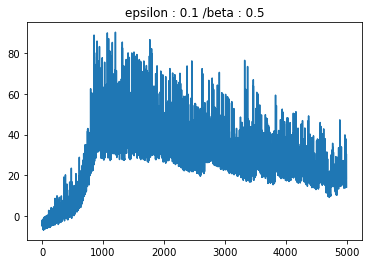

In [16]:
# 네트워크 생성
net = Network(state_dim = STATE_DIM,
              hidden_unit = 256,
              action_dim = ACTION_DIM)

# training loop 만들기
ppo = PPO(env = env, net = net, lr = LR)

# 훈련
ppo.train(n_epoch = N_EPOCH, k_epoch = K_EPOCH, t_horizion = T_HORIZION,
          Lambda = LAMBDA, gamma = GAMMA, epsilon = EPSILON, beta = BETA)

# plot
plt.title(f'epsilon : {EPSILON} /beta : {BETA}')
#plt.xticks('Epoch')
#plt.yticks('Score')
plt.plot(ppo.loss_record)
plt.show()

- https://blog.naver.com/nsm4421/222267767123